In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, stats

rng = np.random.default_rng(14159)

# Parameters and Model

In [2]:
# Parameters

p = 2000
n = 1000
K = 3 # number of classes
mu_norm = np.array([3, 4, 5]) # norm of mu_1, ..., mu_K
prop = np.array([1/3, 1/3, 1/3]) # size of each class

In [3]:
# Model

c = p/n
M = rng.standard_normal((p, K))
M = M*mu_norm/linalg.norm(M, axis=0) # cluster means

# Construct J (class indicator)
J = np.zeros((n, K), dtype=int)
a, b = 0, 0
idx = np.round(np.cumsum(prop)*n).astype(int)
for k in range(K):
    a, b = b, idx[k]
    J[a:b, k] = 1

P = M@J.T # signal
W = rng.standard_normal((p, n)) # noise
X = P+W # data matrix (signal + noise)
ker = X.T@X/p # kernel matrix

# Construct L, V such that P = LV^T
d = np.sum(J, axis=0)
L = M@np.diag(d**.5)
V = J@np.diag(d**-.5)
Lambda = L.T@L/n

# Computations

In [4]:
# Empirical eigenvalues and eigenvectors of the kernel matrix
eigvals, eigvecs = linalg.eigh(ker)

In [5]:
# Marchenko-Pastur distribution
Em, Ep = (1-np.sqrt(1/c))**2, (1+np.sqrt(1/c))**2
MP = lambda x: np.sqrt(np.maximum(0, (x-Em)*(Ep-x)))*c/(2*np.pi*x)

# Spikes
ell = np.maximum(np.sqrt(c), linalg.eigh(Lambda, eigvals_only=True))
spike_pos = (ell+c)*(ell+1)/(ell*c) # spike positions
spike_align = 1-(ell+c)/(ell*(ell+1)) # spike alignments

In [6]:
# Expected spike eigenvectors (deterministic part)
order = np.argsort(mu_norm)[::-1]
vecs = np.zeros((n, K))
for k in range(K):
    if eigvecs[:, -k-1]@V[:, order[k]] < 0:
        eigvecs[:, -k-1] *= -1 # sign correction
    vecs[:, -k-1] = np.sqrt(spike_align[order[k]])*V[:, order[k]]
residuals = eigvecs[:, -K:]-vecs

# Plots

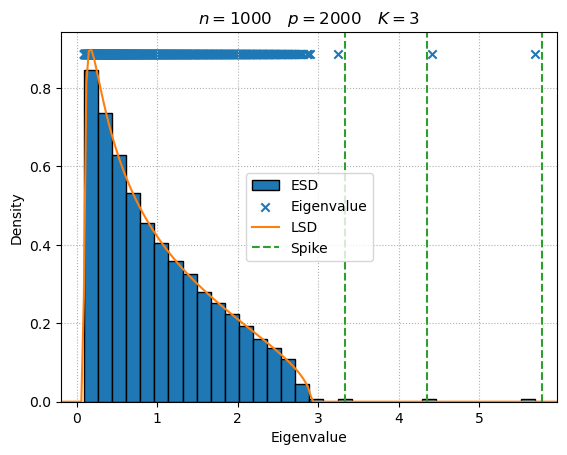

In [7]:
# Eigenvalue distribution

plt.hist(eigvals, density=True, bins='sqrt', edgecolor='black', color='C0', zorder=2, label="ESD")
ymin, ymax = plt.ylim()
plt.scatter(eigvals, [ymax]*n, marker='x', color='C0', label="Eigenvalue")

xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 200)
plt.plot(xx, MP(xx), color='C1', label="LSD")
plt.xlim(xmin, xmax)

vline = None
for l in spike_pos:
    vline = plt.axvline(x=l, ls='--', color='C2')
if vline:
    vline.set_label("Spike")

plt.grid(ls=':')
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.title("$n = {{{}}} \\quad p = {{{}}} \\quad K = {{{}}}$".format(n, p, K))
plt.show()

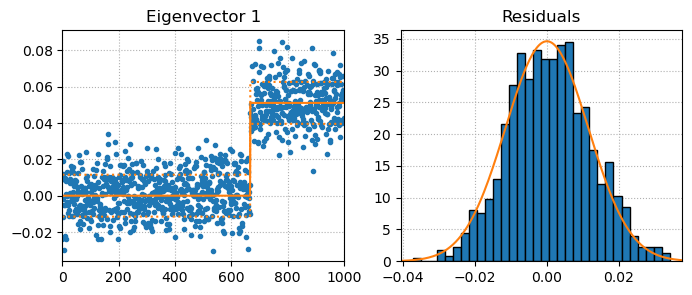

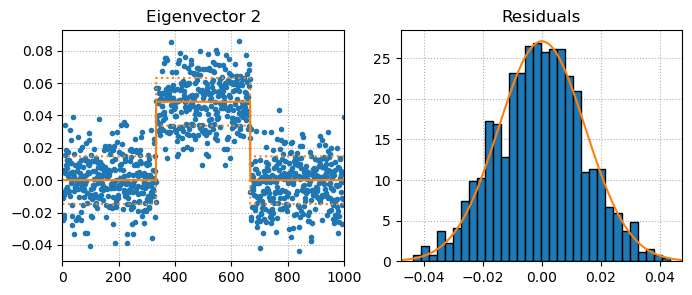

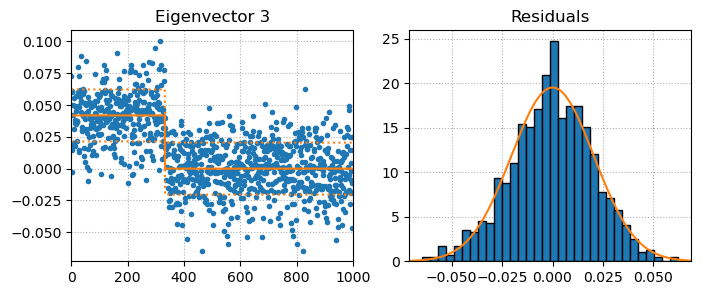

In [8]:
# Spike eigenvectors

for k in range(K):
    std = np.sqrt((1-spike_align[-k-1])/n)
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].plot(eigvecs[:, -k-1], ls='', marker='.', color='C0')
    ax[0].plot(vecs[:, -k-1], color='C1')
    ax[0].plot(vecs[:, -k-1]+std, ls=':', color='C1')
    ax[0].plot(vecs[:, -k-1]-std, ls=':', color='C1')
    ax[0].set_xlim(0, n)
    ax[0].grid(ls=':')
    ax[0].set_title("Eigenvector {}".format(k+1))
    ax[1].hist(residuals[:, -k-1], density=True, bins='sqrt', edgecolor='black', zorder=2)
    xmin, xmax = ax[1].get_xlim()
    xx = np.linspace(xmin, xmax, 200)
    yy = stats.norm.pdf(xx, loc=0, scale=np.sqrt((1-spike_align[-k-1])/n))
    plt.plot(xx, yy)
    ax[1].set_xlim(xmin, xmax)
    ax[1].grid(ls=':')
    ax[1].set_title("Residuals")
    plt.show()